# Internship Tasks 
## Level(Basic)

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans



## Preprocess:

In [5]:
df=pd.read_csv("Stock Prices Data Set.csv", parse_dates=["date"])
df.columns=[c.strip().lower() for c in df.columns]
df=df.sort_values(["symbol","date"]).drop_duplicates(["symbol","date"]).reset_index(drop=True)
assert df.duplicated(["symbol","date"]).sum()==0, "Duplicates removal was unsuccessful"
print(df.head())



  symbol       date   open    high    low  close   volume
0      A 2014-01-02  57.10  57.100  56.15  56.21  1916160
1      A 2014-01-03  56.39  57.345  56.26  56.92  1866651
2      A 2014-01-06  57.40  57.700  56.56  56.64  1777472
3      A 2014-01-07  56.95  57.630  56.93  57.45  1463208
4      A 2014-01-08  57.33  58.540  57.17  58.39  2659468


In [6]:
meta_columns=["date"]
catagorical_columns=["symbol"]
numerical_columns=["open","high","low","close","volume"]
print(missingset:=set(meta_columns+catagorical_columns+numerical_columns)-set(df.columns))

set()


In [7]:
miss_count = df[numerical_columns + catagorical_columns].isna().sum().sort_values(ascending=False)
miss_pct = (df[numerical_columns+ catagorical_columns].isna().mean()*100).round(2)
print("Missing counts:\n",miss_count)
print("\nMissing %:\n", miss_pct)


Missing counts:
 open      11
high       8
low        8
close      0
volume     0
symbol     0
dtype: int64

Missing %:
 open      0.0
high      0.0
low       0.0
close     0.0
volume    0.0
symbol    0.0
dtype: float64


In [8]:
dates = np.sort(df["date"].unique())
cutoff = dates[int(0.8 * len(dates))]
train_mask = df["date"] <= cutoff
test_mask  = df["date"] >  cutoff

train_df = df.loc[train_mask].copy()
test_df  = df.loc[test_mask].copy()

print("Train window:", train_df["date"].min(), "→", train_df["date"].max())
print("Test  window:", test_df["date"].min(),  "→", test_df["date"].max())
assert train_df["date"].max() < test_df["date"].min()


Train window: 2014-01-02 00:00:00 → 2017-03-15 00:00:00
Test  window: 2017-03-16 00:00:00 → 2017-12-29 00:00:00


In [9]:
num_mean_cols, num_median_cols = [], []
for col in numerical_columns:
    s = train_df[col].astype(float)
    skew = s.skew(skipna=True)
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0 or s.isna().all():
        continue
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    out_frac = ((s < lower) | (s > upper)).mean()
    if abs(skew) > 1 or out_frac > 0.01:
        num_median_cols.append(col)
    else:
        num_mean_cols.append(col)

print("Mean-impute cols:", num_mean_cols)
print("Median-impute cols:", num_median_cols)


Mean-impute cols: []
Median-impute cols: ['open', 'high', 'low', 'close', 'volume']


In [10]:
numerical_mean_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler",  StandardScaler())
])
numerical_median_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])
catagorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

transformers = []
if num_mean_cols:
    transformers.append(("num_mean",   numerical_mean_pipe,   num_mean_cols))
if num_median_cols:
    transformers.append(("num_median", numerical_median_pipe, num_median_cols))
if catagorical_columns:
    transformers.append(("cat_nom",    catagorical_pipe,    catagorical_columns))

preprocessor = ColumnTransformer(transformers=transformers, remainder="drop")

print(df.head())

  symbol       date   open    high    low  close   volume
0      A 2014-01-02  57.10  57.100  56.15  56.21  1916160
1      A 2014-01-03  56.39  57.345  56.26  56.92  1866651
2      A 2014-01-06  57.40  57.700  56.56  56.64  1777472
3      A 2014-01-07  56.95  57.630  56.93  57.45  1463208
4      A 2014-01-08  57.33  58.540  57.17  58.39  2659468


In [11]:
X_cols = numerical_columns + catagorical_columns
X_train = train_df[X_cols]
X_test  = test_df[X_cols]

preprocessor.fit(X_train)             
Xt_train = preprocessor.transform(X_train)
Xt_test  = preprocessor.transform(X_test)

print("Transformed shapes:", Xt_train.shape, Xt_test.shape)



Transformed shapes: (396439, 505) (101033, 505)


## Modeling : Linear Regression


In [12]:
train_df["return"] = train_df.groupby("symbol")["close"].pct_change()
train_df["targeted_return"] = train_df.groupby("symbol")["return"].shift(-1)
train_df["targeted_direction"] = (train_df["targeted_return"] > 0).astype(int)
test_df["return"] = test_df.groupby("symbol")["close"].pct_change()
test_df["targeted_return"] = test_df.groupby("symbol")["return"].shift(-1)
test_df["targeted_direction"] = (test_df["targeted_return"] > 0).astype(int)

train_df = train_df.dropna(subset=["targeted_return", "targeted_direction"])
test_df = test_df.dropna(subset=["targeted_return", "targeted_direction"])

In [13]:
feature_columns = ["open","high","low","close","volume","symbol"]

X_train = train_df[feature_columns]
X_test = test_df[feature_columns]
y_reg_train = train_df["targeted_return"]
y_reg_test = test_df["targeted_return"]
y_class_train = train_df["targeted_direction"]
y_class_test = test_df["targeted_direction"]


In [14]:
print("Expected numeric:", numerical_columns)
print("Expected categorical:", catagorical_columns)
print("X_train columns:", X_train.columns.tolist())
print("X_test  columns:", X_test.columns.tolist())

missing_train_num = [c for c in numerical_columns if c not in X_train.columns]
missing_train_cat = [c for c in catagorical_columns if c not in X_train.columns]
missing_test_num  = [c for c in numerical_columns if c not in X_test.columns]
missing_test_cat  = [c for c in catagorical_columns if c not in X_test.columns]

print("Missing in TRAIN (num):", missing_train_num)
print("Missing in TRAIN (cat):", missing_train_cat)
print("Missing in TEST  (num):", missing_test_num)
print("Missing in TEST  (cat):", missing_test_cat)


Expected numeric: ['open', 'high', 'low', 'close', 'volume']
Expected categorical: ['symbol']
X_train columns: ['open', 'high', 'low', 'close', 'volume', 'symbol']
X_test  columns: ['open', 'high', 'low', 'close', 'volume', 'symbol']
Missing in TRAIN (num): []
Missing in TRAIN (cat): []
Missing in TEST  (num): []
Missing in TEST  (cat): []


In [15]:
preprocessor.fit(X_train)
X_transformed_train=preprocessor.transform(X_train)
X_transformed_test=preprocessor.transform(X_test)

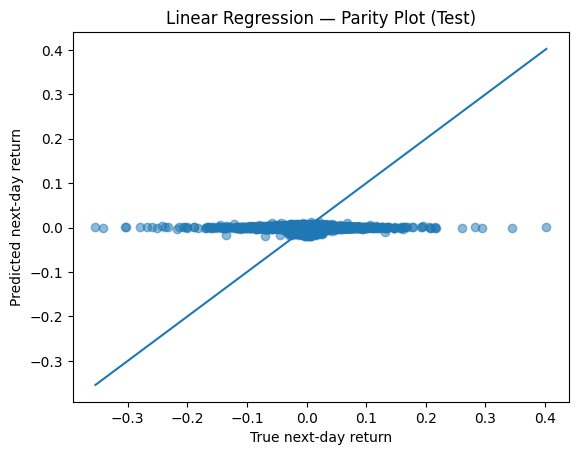

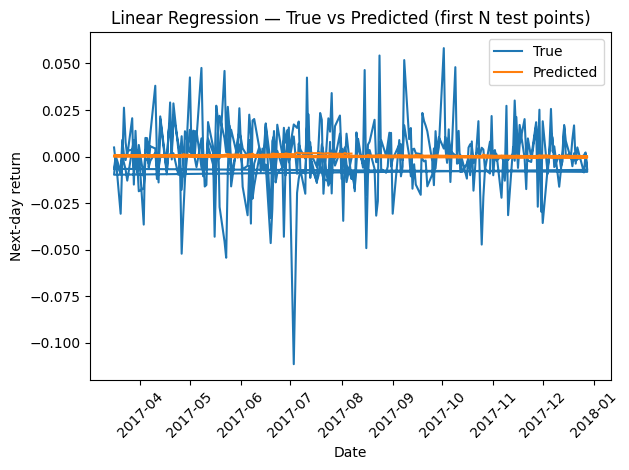

Linear Regression Results:
 RMSE: 0.014445311535200659
 R²: -0.008109343633603272


In [16]:
linear_regression = LinearRegression()
linear_regression.fit(X_transformed_train, y_reg_train)  
y_regression_predict = linear_regression.predict(X_transformed_test)

mse = mean_squared_error(y_reg_test, y_regression_predict)  
rmse = np.sqrt(mse)
r2 = r2_score(y_reg_test, y_regression_predict)  

plt.figure()
plt.scatter(y_reg_test, y_regression_predict, alpha=0.5)  
mn = float(min(y_reg_test.min(), y_regression_predict.min()))
mx = float(max(y_reg_test.max(), y_regression_predict.max()))
plt.plot([mn, mx], [mn, mx])   
plt.xlabel("True next-day return")
plt.ylabel("Predicted next-day return")
plt.title("Linear Regression — Parity Plot (Test)")
plt.show()

N = min(500, len(y_reg_test))
dates_ts = test_df["date"].iloc[:N]  
y_true_ts = y_reg_test.iloc[:N]      
y_pred_ts = y_regression_predict[:N]

plt.figure()
plt.plot(dates_ts, y_true_ts, label="True")
plt.plot(dates_ts, y_pred_ts, label="Predicted")
plt.xlabel("Date")
plt.ylabel("Next-day return")
plt.title("Linear Regression — True vs Predicted (first N test points)")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Linear Regression Results:")
print(" RMSE:", rmse)
print(" R²:", r2)

In [17]:
df.columns = [c.strip().lower() for c in df.columns]
if "close" not in df.columns:
    for cand in ["adj_close", "adjclose", "close_price", "closing_price", "last", "price"]:
        if cand in df.columns:
            df["close"] = df[cand]
            break

df = df.sort_values(["symbol","date"]).reset_index(drop=True)
df["return"] = df.groupby("symbol")["close"].pct_change()
df["targeted_return"] = df.groupby("symbol")["return"].shift(-1)
df["targeted_direction"] = (df["targeted_return"] > 0).astype(int)

df_model = df.dropna(subset=["targeted_return", "targeted_direction"]).reset_index(drop=True)
numerical_columns   = ["open","high","low","close","volume"]
categorical_columns = ["symbol"]
feature_columns = numerical_columns + categorical_columns

X = df_model[feature_columns].copy()
y_regression  = df_model["targeted_return"].copy()
y_classifier  = df_model["targeted_direction"].copy()
cutoff = df_model["date"].quantile(0.8)
train_mask = df_model["date"] <= cutoff
test_mask  = df_model["date"] >  cutoff

X_train, X_test = X.loc[train_mask].copy(), X.loc[test_mask].copy()
y_classifier_train, y_classifier_test = y_classifier.loc[train_mask].copy(), y_classifier.loc[test_mask].copy()
assert X_train.index.equals(y_classifier_train.index)
assert X_test.index.equals(y_classifier_test.index)
preprocessor.fit(X_train)
Xt_train = preprocessor.transform(X_train)
Xt_test  = preprocessor.transform(X_test)
assert Xt_train.shape[0] == len(y_classifier_train)
assert Xt_test.shape[0]  == len(y_classifier_test)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(Xt_train, y_classifier_train)


,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5)  
knn.fit(Xt_train, y_classifier_train)
y_clf_pred = knn.predict(Xt_test)
y_true = y_classifier_test.values
y_pred = y_clf_pred
dates_test = df_model.loc[test_mask, "date"].to_numpy()

def arrow(v):
    return "↑" if v == 1 else "↓"

total_predictions = len(y_true)
max_frames = 400  
step_size = max(1, total_predictions // max_frames)  
frame_indices = list(range(0, total_predictions, step_size))

print(f"Total predictions: {total_predictions}")
print(f"Animation frames: {len(frame_indices)}")
print(f"Showing every {step_size}th prediction")
print(f"Expected runtime: ~{len(frame_indices) * 0.05:.1f} seconds")

fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

txt_title = ax.text(0.02, 0.92, "", transform=ax.transAxes, fontsize=14, fontweight='bold')
txt_line1 = ax.text(0.02, 0.75, "", transform=ax.transAxes, fontsize=12) 
txt_line2 = ax.text(0.02, 0.64, "", transform=ax.transAxes, fontsize=12) 
txt_line3 = ax.text(0.02, 0.48, "", transform=ax.transAxes, fontsize=10) 
txt_progress = ax.text(0.02, 0.35, "", transform=ax.transAxes, fontsize=10, color='gray')

recent_window = 25 

def init():
    txt_title.set_text("KNN Classification — S&P 500 Stock Direction Prediction")
    txt_line1.set_text("")
    txt_line2.set_text("")
    txt_line3.set_text("")
    txt_progress.set_text("")
    return txt_title, txt_line1, txt_line2, txt_line3, txt_progress

def update(frame_num):
    i = frame_indices[frame_num] 
    
 
    acc = (y_pred[:i+1] == y_true[:i+1]).mean()
    

    cur_date = str(dates_test[i])[:10] if i < len(dates_test) else "N/A"
    prediction_status = "✓" if y_pred[i] == y_true[i] else "✗"
    
    txt_line1.set_text(
        f"Prediction {i+1:,}/{total_predictions:,}  |  Date: {cur_date}\n"
        f"True: {arrow(int(y_true[i]))}   Pred: {arrow(int(y_pred[i]))}   {prediction_status}"
    )
    
    txt_line2.set_text(f"Cumulative Accuracy: {acc:.3f} ({acc*100:.1f}%)")
    start_window = max(0, i - recent_window + 1)
    end_window = min(i + 1, len(y_true))
    
    w_true = ''.join(arrow(int(v)) for v in y_true[start_window:end_window])
    w_pred = ''.join(arrow(int(v)) for v in y_pred[start_window:end_window])
    
    txt_line3.set_text(
        f"Last {end_window - start_window} actual decisions:\n"
        f"True: {w_true}\n"
        f"Pred: {w_pred}"
    )
    

    progress = (frame_num + 1) / len(frame_indices) * 100
    txt_progress.set_text(f"Animation Progress: {progress:.1f}%")
    
    return txt_title, txt_line1, txt_line2, txt_line3, txt_progress


ani = FuncAnimation(
    fig, update, 
    frames=len(frame_indices), 
    init_func=init, 
    interval=50,  
    blit=True,
    repeat=False  
)

plt.tight_layout()
plt.show()
acc = accuracy_score(y_classifier_test, y_clf_pred)
prec = precision_score(y_classifier_test, y_clf_pred)
rec = recall_score(y_classifier_test, y_clf_pred)
f1 = f1_score(y_classifier_test, y_clf_pred)

print("\n" + "="*50)
print("KNN Classifier Final Results:")
print("="*50)
print(f"Dataset: {total_predictions:,} predictions stocks")
print(f"Time period: {str(dates_test[0])[:10]} to {str(dates_test[-1])[:10]}")
print(f"Accuracy : {acc:.4f} ({acc*100:.2f}%)")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1 Score : {f1:.4f}")
print("\nConfusion Matrix:")
cm = confusion_matrix(y_classifier_test, y_clf_pred)
print(f"{'':>12} Predicted")
print(f"{'':>12} Down  Up")
print(f"Actual Down  {cm[0,0]:>4} {cm[0,1]:>4}")
print(f"       Up    {cm[1,0]:>4} {cm[1,1]:>4}")

baseline_acc = max(y_true.mean(), 1 - y_true.mean())
print(f"\nBaseline (always predict majority): {baseline_acc:.4f}")
print(f"Model improvement: {((acc - baseline_acc) / baseline_acc * 100):+.2f}%")
